In [1]:
# 02_analysis.ipynb 
# Imports and basic setup for analysis
"""
02_analysis.ipynb builds on top of that pipeline and focuses on evaluation and interpretation: 
    regime stability across seeds and samples, macroeconomic alignment, and simple ROC-style analysis 
    for downturn detection.
"""
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
from itertools import combinations
from sklearn.metrics import roc_curve, auc

from hmm_utils import (     # from mini-project style HMM
    baum_welch_train,      
    viterbi_decode,        
    forward_pass,          
    backward_pass,        
    compute_posteriors,   
    count_num_params,
    compute_aic_bic,
)

plt.rcParams["figure.figsize"] = (10, 4)
plt.rcParams["axes.grid"] = True

DATA_PATH = Path("data") / "hpi_quarterly_clean.csv"

In [2]:
def load_and_preprocess_hpi(filepath):
    """
    Load the clean FHFA HPI series produced by 01_final_pipeline.ipynb.

    The file is expected to have at least:
      - 'date' column (timestamp)
      - 'hpi' column (index level)
      - optionally existing 'log_hpi' and 'ret' columns
    """
    df = pd.read_csv(filepath)

    # ensure date is datetime and sorted
    if "date" in df.columns:
        df["date"] = pd.to_datetime(df["date"])
        df = df.sort_values("date").reset_index(drop=True)
    else:
        df = df.sort_index().reset_index(drop=True)

    if "hpi" not in df.columns:
        raise ValueError("Clean file must contain an 'hpi' column.")

    # Recompute log_hpi / ret just to be safe
    df["log_hpi"] = np.log(df["hpi"])
    df["ret"] = df["log_hpi"].diff()
    df = df.dropna(subset=["ret"]).reset_index(drop=True)

    return df


df = load_and_preprocess_hpi(DATA_PATH)
df.head()

,year,quarter,hpi,log_hpi,ret,date
0,1991,3,100.17,4.606869,0.001699,1991-07-01
1,1991,4,101.05,4.615615,0.008747,1991-10-01
2,1992,1,102.27,4.627616,0.012001,1992-01-01
3,1992,2,102.12,4.626149,-0.001468,1992-04-01
4,1992,3,102.96,4.634341,0.008192,1992-07-01


In [3]:
# Wrapper to train HMM for a single K and random seed

def train_hmm_with_seed(observations, K, max_iters=100, n_restarts=3, seed=0):
    """
    Train a Gaussian HMM with K states for a given random seed.

    This is basically the same pattern as in final_pipeline.
    It uses baum_welch_train and viterbi_decode from the mini-project style code.
    """
    T = len(observations)

    best_params, loglik_trace = baum_welch_train(
        observations,
        K,
        max_iters=max_iters,
        tol=1e-6,
        n_restarts=n_restarts,
        seed=seed,
    )

    final_loglik = loglik_trace[-1]
    num_params = count_num_params(K)
    aic, bic = compute_aic_bic(final_loglik, num_params, T)
    viterbi_path = viterbi_decode(observations, best_params)

    result = {
        "K": K,
        "params": best_params,
        "loglik_trace": loglik_trace,
        "final_loglik": final_loglik,
        "AIC": aic,
        "BIC": bic,
        "viterbi_path": viterbi_path,
        "seed": seed,
    }
    return result

In [4]:
# Regime stability across multiple random seeds for a fixed K (for example, K = 3)

observations = df["ret"].values

K_target = 3
seeds = [0, 1, 2, 3, 4]   # you can extend this if you want

results_multi_seed = []

for s in seeds:
    print(f"Training HMM with K={K_target}, seed={s}...")
    res = train_hmm_with_seed(observations, K_target, max_iters=100, n_restarts=2, seed=s)
    results_multi_seed.append(res)

print("Done training multiple seeds.")

Training HMM with K=3, seed=0...
Training HMM with K=3, seed=1...
Training HMM with K=3, seed=2...
Training HMM with K=3, seed=3...
Training HMM with K=3, seed=4...
Done training multiple seeds.


In [5]:
# Compute pairwise similarity of Viterbi paths (Hamming-based agreement)

def path_agreement(path1, path2):
    """
    Simple Hamming-style agreement between two integer paths.

    Note: This does not try to fix label switching.
    For this course project, a rough measure is fine.
    """
    assert len(path1) == len(path2)
    return np.mean(path1 == path2)


n_runs = len(results_multi_seed)
agreement_matrix = np.zeros((n_runs, n_runs))

for i, j in combinations(range(n_runs), 2):
    p_i = results_multi_seed[i]["viterbi_path"]
    p_j = results_multi_seed[j]["viterbi_path"]
    score = path_agreement(p_i, p_j)
    agreement_matrix[i, j] = score
    agreement_matrix[j, i] = score

np.fill_diagonal(agreement_matrix, 1.0)

agreement_matrix

array([[1.        , 0.18382353, 0.68382353, 0.05882353, 0.68382353],
       [0.18382353, 1.        , 0.        , 0.75      , 0.        ],
       [0.68382353, 0.        , 1.        , 0.125     , 1.        ],
       [0.05882353, 0.75      , 0.125     , 1.        , 0.125     ],
       [0.68382353, 0.        , 1.        , 0.125     , 1.        ]])

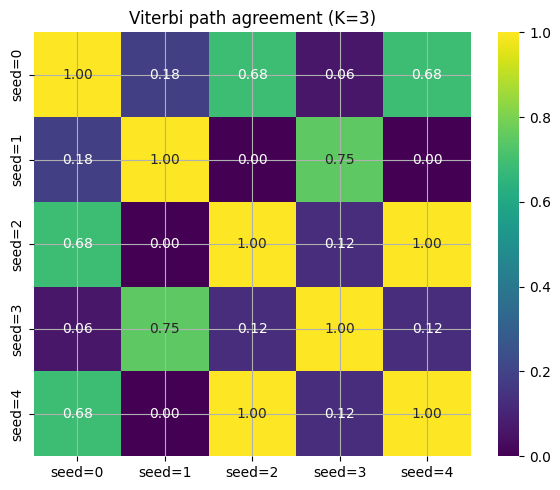

In [6]:
# Plot a heatmap of path agreement across seeds

import seaborn as sns  # if you prefer, you can use plain matplotlib, but seaborn is nice for heatmaps

labels = [f"seed={r['seed']}" for r in results_multi_seed]

plt.figure(figsize=(6, 5))
sns.heatmap(agreement_matrix, annot=True, fmt=".2f",
            xticklabels=labels, yticklabels=labels,
            vmin=0.0, vmax=1.0, cmap="viridis")
plt.title(f"Viterbi path agreement (K={K_target})")
plt.tight_layout()
plt.show()

In [7]:
# Look at means and variances of each state across seeds

all_means = []
all_vars = []

for res in results_multi_seed:
    params = res["params"]
    all_means.append(params["means"])
    all_vars.append(params["vars"])

all_means = np.array(all_means)  # shape: (n_runs, K)
all_vars = np.array(all_vars)

print("State means across seeds:\n", all_means)
print("\nState variances across seeds:\n", all_vars)

State means across seeds:
 [[ 0.01200322 -0.00840613  0.03008126]
 [-0.01303945  0.01152471  0.03118947]
 [ 0.01152471  0.03118947 -0.01303944]
 [ 0.03118938  0.01152471 -0.01303933]
 [ 0.01152471  0.03118951 -0.01303944]]

State variances across seeds:
 [[2.41359610e-05 1.28683555e-04 8.40250105e-05]
 [9.33873784e-05 2.79266087e-05 7.36417165e-05]
 [2.79266078e-05 7.36417111e-05 9.33874055e-05]
 [7.36424754e-05 2.79264977e-05 9.33886146e-05]
 [2.79266294e-05 7.36413902e-05 9.33874230e-05]]


/tmp/ipykernel_6867/2814658098.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[0].boxplot(all_means, labels=[f"state {k}" for k in range(K_target)])
/tmp/ipykernel_6867/2814658098.py:8: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1].boxplot(all_vars, labels=[f"state {k}" for k in range(K_target)])


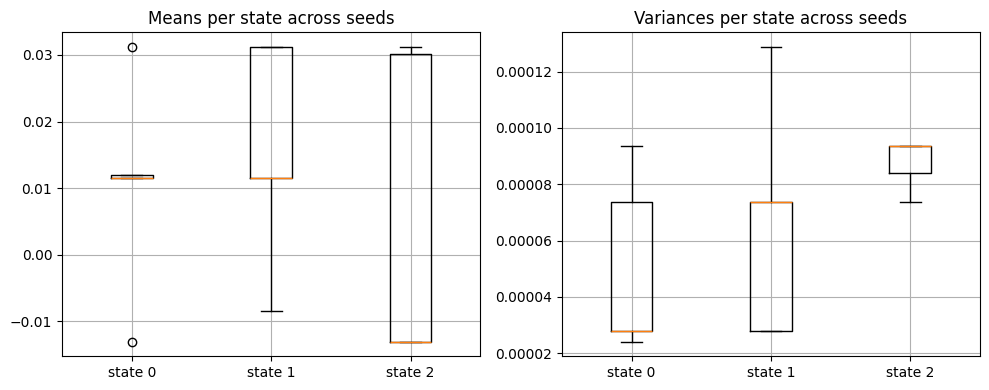

In [8]:
# boxplots for means and variances

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

axes[0].boxplot(all_means, labels=[f"state {k}" for k in range(K_target)])
axes[0].set_title("Means per state across seeds")

axes[1].boxplot(all_vars, labels=[f"state {k}" for k in range(K_target)])
axes[1].set_title("Variances per state across seeds")

plt.tight_layout()
plt.show()

In [ ]:
# Macro alignment: define some rough macro episodes and inspect regime usage

# Choose one representative run for macro analysis
best_res = results_multi_seed[0]   # you can also pick the best BIC one
path = best_res["viterbi_path"]

df_macro = df.copy()
df_macro["regime"] = path  # 0..K-1


# Example macro windows (you should tune these dates to real episodes)
# Have changed the dates to align with the timeline of the housing prices and recent crash
macro_windows = [
    ("Early-2000s",         "2000-01-01", "2003-12-31"),
    ("Housing boom",        "2004-01-01", "2006-12-31"),
    ("Financial crisis",    "2007-01-01", "2009-12-31"),
    ("Recovery",            "2010-01-01", "2015-12-31"),
    ("Recent",              "2016-01-01", "2024-12-31"),
]


summary_rows = []

for name, start, end in macro_windows:
    mask = (df_macro["date"] >= start) & (df_macro["date"] <= end)
    sub = df_macro[mask]
    if len(sub) == 0:
        continue

    counts = sub["regime"].value_counts(normalize=True).sort_index()
    row = {"Period": name, "T": len(sub)}
    for k in range(K_target):
        row[f"regime_{k}_share"] = counts.get(k, 0.0)
    summary_rows.append(row)

df_macro_summary = pd.DataFrame(summary_rows)
df_macro_summary

,Period,T,regime_0_share,regime_1_share,regime_2_share
0,Early-2000s,16,0.937500,0.000000,0.062500
1,Housing boom,12,0.000000,0.250000,0.750000
2,Financial crisis,12,0.000000,1.000000,0.000000
3,Recovery,24,0.666667,0.333333,0.000000
4,Recent,36,0.722222,0.055556,0.222222


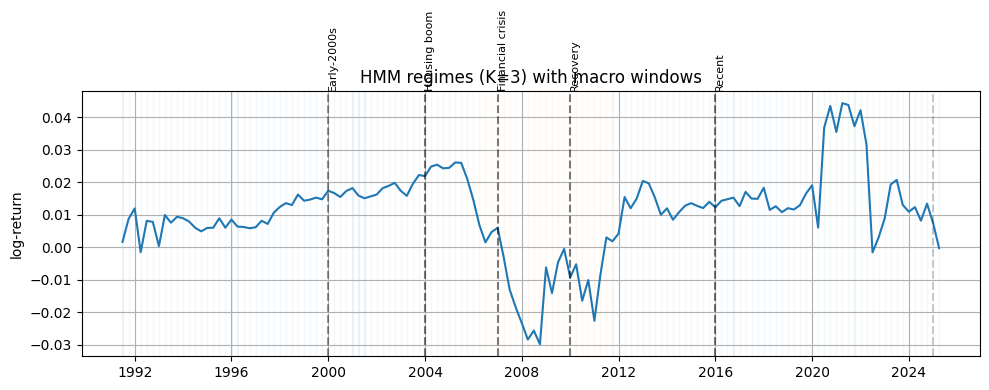

In [18]:
# Plot the returns with regime bands and mark macro windows for visual alignment

state_colors = ["tab:blue", "tab:orange", "tab:green", "tab:red"]

fig, ax = plt.subplots(figsize=(10, 4))

ax.plot(df_macro["date"], df_macro["ret"], label="log-return")
ax.set_ylabel("log-return")
ax.set_title(f"HMM regimes (K={K_target}) with macro windows")

# regime bands
for t in range(len(df_macro)):
    ax.axvspan(
        df_macro["date"].iloc[t],
        df_macro["date"].iloc[t] + pd.Timedelta("1D"),
        color=state_colors[df_macro["regime"].iloc[t]],
        alpha=0.06,
    )

# vertical lines for macro window boundaries
for name, start, end in macro_windows:
    ax.axvline(pd.to_datetime(start), color="k", linestyle="--", alpha=0.4)
    ax.axvline(pd.to_datetime(end), color="k", linestyle="--", alpha=0.2)
    ax.text(pd.to_datetime(start), ax.get_ylim()[1],
            name, rotation=90, verticalalignment="bottom", fontsize=8)

plt.tight_layout()
plt.show()

In [20]:
# Construct a simple downturn proxy label

df_down = df_macro.copy()

# rolling 3-month cumulative return
df_down["ret_3m"] = df_down["ret"].rolling(window=3).sum()

# downturn label: 1 if 3-month sum < 0, else 0
df_down["downturn_label"] = (df_down["ret_3m"] < 0).astype(int)

df_down[["date", "ret", "ret_3m", "downturn_label"]].head(10)

,date,ret,ret_3m,downturn_label
0,1991-07-01,0.001699,NaN,0
1,1991-10-01,0.008747,NaN,0
2,1992-01-01,0.012001,0.022446,0
3,1992-04-01,-0.001468,0.019280,0
4,1992-07-01,0.008192,0.018725,0
5,1992-10-01,0.007836,0.014561,0
6,1993-01-01,0.000385,0.016414,0
7,1993-04-01,0.009968,0.018190,0
8,1993-07-01,0.007601,0.017955,0
9,1993-10-01,0.009421,0.026990,0


In [12]:
# Get smoothed posterior gamma_t(k) and build a "downturn score" -1

# Use the same params as best_res
params = best_res["params"]

# compute posteriors (gamma_t(k))
log_alpha, loglik = forward_pass(observations, params)
log_beta = backward_pass(observations, params)
gamma = compute_posteriors(log_alpha, log_beta)   # shape (T, K)

gamma[:5]

array([[9.99999962e-01, 3.82154097e-08, 2.27914356e-36],
       [9.99968422e-01, 1.18422971e-08, 3.15657047e-05],
       [9.99615867e-01, 1.72915175e-05, 3.66841072e-04],
       [9.99609746e-01, 3.82846786e-04, 7.40701350e-06],
       [9.99858694e-01, 1.25734424e-04, 1.55717009e-05]])

In [13]:
# Pick the "down-like" regime as the state with smallest mean -2

means = params["means"]
down_state = np.argmin(means)
down_state

np.int64(1)

In [14]:
# Build a simple downturn score from smoothed posterior -3

downturn_score = gamma[:, down_state]   # 1D array of probabilities

df_down["downturn_score"] = downturn_score
df_down[["date", "downturn_label", "downturn_score"]].head()

,date,downturn_label,downturn_score
0,1991-07-01,0,3.821541e-08
1,1991-10-01,0,1.184230e-08
2,1992-01-01,0,1.729152e-05
3,1992-04-01,0,3.828468e-04
4,1992-07-01,0,1.257344e-04


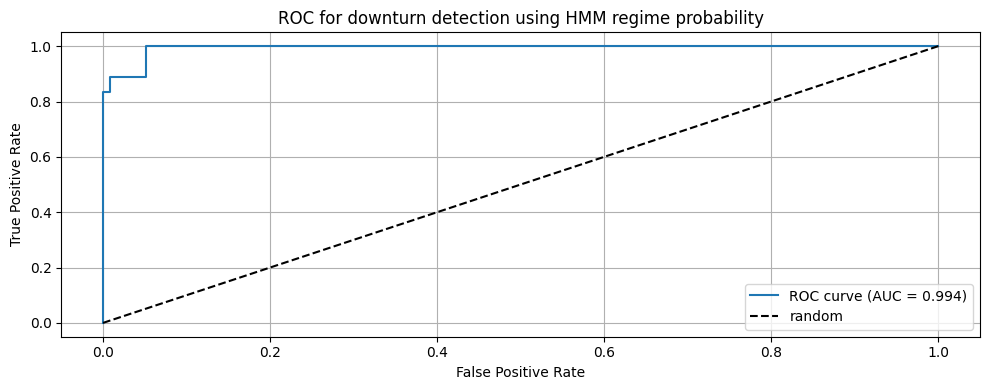

AUC for downturn detection: 0.994


In [15]:
# ROC curve and AUC for the downturn label vs HMM downturn_score

# Drop early rows where ret_3m is NaN
mask_valid = ~df_down["ret_3m"].isna()
y_true = df_down.loc[mask_valid, "downturn_label"].values
y_score = df_down.loc[mask_valid, "downturn_score"].values

fpr, tpr, thresholds = roc_curve(y_true, y_score)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], "k--", label="random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC for downturn detection using HMM regime probability")
plt.legend()
plt.tight_layout()
plt.show()

print(f"AUC for downturn detection: {roc_auc:.3f}")

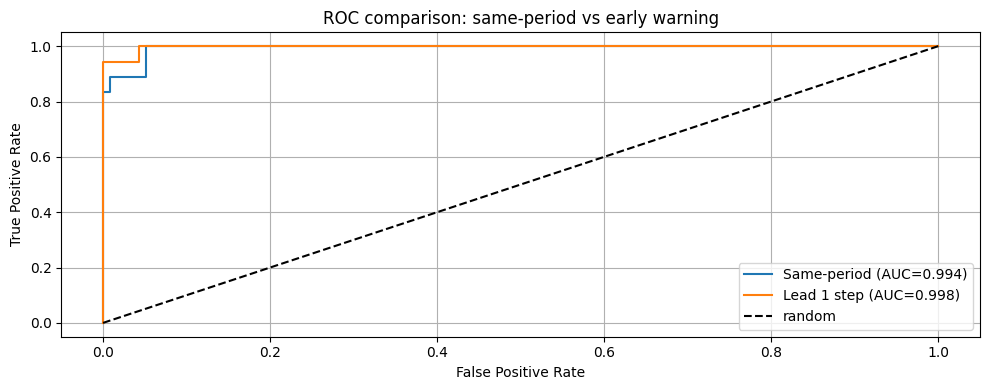

In [16]:
# Simple "early warning" check: shift the score by 1 period into the past

lead = 1  # you can also try 2 or 3
df_down[f"downturn_score_lead{lead}"] = df_down["downturn_score"].shift(lead)

mask_valid_lead = (~df_down["ret_3m"].isna()) & (~df_down[f"downturn_score_lead{lead}"].isna())
y_true_lead = df_down.loc[mask_valid_lead, "downturn_label"].values
y_score_lead = df_down.loc[mask_valid_lead, f"downturn_score_lead{lead}"].values

fpr_lead, tpr_lead, _ = roc_curve(y_true_lead, y_score_lead)
roc_auc_lead = auc(fpr_lead, tpr_lead)

plt.figure()
plt.plot(fpr, tpr, label=f"Same-period (AUC={roc_auc:.3f})")
plt.plot(fpr_lead, tpr_lead, label=f"Lead {lead} step (AUC={roc_auc_lead:.3f})")
plt.plot([0, 1], [0, 1], "k--", label="random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC comparison: same-period vs early warning")
plt.legend()
plt.tight_layout()
plt.show()